In [1]:
import numpy as np
import os
import sys
import copy

import torch
torch.set_num_threads(os.cpu_count())
from torch import nn

import importlib
import pickle as pk

import matplotlib as mpl
import matplotlib.pyplot as plt

from pipnet import data
from pipnet import model
from pipnet import utils

#import nmrglue as ng
import scipy
import scipy.io

device = "cuda" if torch.cuda.is_available() else "cpu"

np.random.seed(123)

In [6]:
model_name = "PIPNet_model"
model_dir = f"../../trained_models/{model_name}/"
fig_dir = f"../../figures/1D/{model_name}/"

sel_wrs = [
    30000., 32000., 34000., 36000., 38000.,
    40000., 42000., 44000., 46000., 48000.,
    50000., 52000., 54000., 56000., 58000., 
    60000., 62000., 64000., 66000., 68000.,
    70000., 72000., 74000., 76000., 78000.,
    80000., 82000., 84000., 86000., 88000.,
    90000., 92000., 94000., 96000., 98000., 100000.
]

#sel_wrs = [
#    40000., 42000., 44000., 46000., 48000.,
#    50000., 52000., 54000., 56000., 58000., 
#    60000., 62000., 64000., 66000., 68000.,
#    70000., 72000., 74000., 76000., 78000.,
#    80000., 82000., 84000., 86000., 88000.,
#    90000., 92000., 94000., 96000., 98000., 100000.
#]

#sel_wrs = [
#    40000., 44000., 48000., 52000., 56000.,
#    60000., 64000., 68000., 72000., 76000., 
#    80000., 84000., 88000., 92000., 96000., 100000.
#]

#sel_wrs = [
#    40000., 46000., 52000., 58000., 64000., 70000., 76000., 
#    82000., 88000., 94000., 100000.
#]

#sel_wrs = [40000., 48000., 56000., 64000., 72000., 80000., 88000., 96000.]

#sel_wrs = [40000., 50000., 60000., 70000., 80000., 90000., 100000.]

dw_max = 1000.

ppm_range = [-5., 20.]

#compounds = ["ampicillin", "aspala", "flutamide", "histidine", "histidine_old", "histidine_1_3",
#             "thymol", "tyrosine", "mdma", "molnupiravir"]
compounds = ["ampicillin", "aspala", "flutamide", "histidine",
             "thymol", "tyrosine", "mdma", "molnupiravir"]

exp_dir = "../../data/experimental_spectra/1D/"

fields = {"ampicillin": 800.,
          "aspala": 800.,
          "flutamide": 800.,
          "histidine": 900.,
          "thymol": 800.,
          "tyrosine": 800.,
          "mdma": 800.,
          "molnupiravir": 900.}

peaks = {"ampicillin": [[0., 1.1], [1.1, 2.], [9., 11.]],
         "aspala": [[0.1, 1.5], [1.5, 2.4], [2.4, 3.], [3.5, 4.5], [4.5, 5.5], [7., 7.8], [12., 13.]],
         "flutamide": [[0., 1.8], [6., 7.5], [7.5, 9.], [9., 11.]],
         "histidine": [[4.5, 6.], [7.8, 8.7], [11.5, 13.5], [16., 18.]],
         "thymol": [[2.8, 4.], [5., 5.8], [5.8, 6.6], [6.6, 7.6], [8.4, 10.4]],
         "tyrosine": [[1.8, 3.4], [6.1, 7.], [9.5, 11.], [12., 13.]],
         "mdma": [[0.5, 1.7]],
         "molnupiravir": [[0.5, 2.], [6.3, 7.5], [9., 10.], [10., 11.5]]}

peaks2 = {"ampicillin": [[0., 1.1], [1.1, 2.], [3., 4.3], [9., 11.]],
          "aspala": [[0.1, 1.5], [1.5, 2.4], [2.4, 3.], [3.5, 4.5], [4.5, 5.5], [7., 7.8], [7.7, 8.5], [12., 13.]],
          "flutamide": [[0., 1.8], [1.8, 2.8], [6., 7.5], [7.5, 9.], [9., 11.]],
          "histidine": [[4.5, 6.], [7., 7.8], [7.8, 8.7], [8.7, 9.5], [11.5, 13.5], [16., 18.]],
          "thymol": [[0., 0.9], [2.8, 4.], [5., 5.8], [5.8, 6.6], [6.6, 7.6], [8.4, 10.4]],
          "tyrosine": [[1.8, 3.4], [4.8, 5.1], [5.1, 5.6], [6.1, 7.], [7.4, 8.], [9.5, 11.], [12., 13.]],
          "mdma": [[0.5, 1.7], [1.7, 2.1], [2.1, 2.4], [2.4, 3.2], [3.1, 4.], [5.8, 6.1], [6.1, 6.4], [6.4, 7.], [9., 9.5], [9.5, 10.]],
          "molnupiravir": [[0.5, 2.], [3.5, 4.], [5., 5.6], [6.3, 7.5], [9., 10.], [10., 11.5]]}

int_regions = {"ampicillin": [[12., 8.5], [8.5, 3.], [3., -2.]],
               "aspala": [[15., 10.], [10., 6.], [6., 3.4], [3.4, 1.5], [1.5, 0.]],
               "flutamide": [[11., 9.], [9., 5.], [5., -2.]],
               "histidine": [[20., 15.], [15., 10.5], [10.5, 6.5], [6.5, 4.2], [4.2, -2.]],
               "thymol": [[12., 8.], [8., 4.5], [4.5, 2.7], [2.7, -2]],
               "tyrosine": [[14., 11.], [11., 9.], [9., 6.1], [6.1, 3.5], [3.5, 0.]],
               "mdma": [[13., 8.], [8., 5.], [5., -1.]],
               "molnupiravir": [[12.0, 8.0], [8.0, 2.0], [2.0, -5.]]
              }

iso_dir = "../../data/experimental_spectra/1D/iso/"

iso_res = {"ampicillin": ["4k", "4k", "4k", "4k"],
           "aspala": ["4k", "4k", "4k", "4k", "4k"],
           "flutamide": ["2k", "2k", "2k", "4k"],
           "histidine": ["4k", "4k", "4k", "4k", "4k"],
           #"histidine": ["900", "900", "900", "900", "900"],
           "thymol": ["4k", "4k", "4k", "4k"],
           "tyrosine": ["4k", "4k", "4k", "4k", "4k"],
           "mdma": ["4k", "4k", "4k", "4k"],
           "molnupiravir": ["4k", "4k", "4k", "4k", "4k", "4k", "4k"]}

iso_parts = {'ampicillin': ['NH3', 'NHAr5', 'Ar6104b', 'Me2'],
             'aspala': ['OH', 'NHNH3', 'CHCH', 'CH2', 'CH3'],
             'flutamide': ['H5b', 'H38', 'H6', 'H101112'],
             'histidine': ['H5', 'H7', 'H618', 'H9', 'H342'],
             #'histidine': ["R1", "R2", "R3", "R4", "R5"],
             'thymol': ['H7', 'H321c', 'H4', 'H556'],
             'tyrosine': ['COOH', 'OH', 'NH3H76', 'H5823', 'H3dia'],
             "mdma": ["R1ph_og_divby1456", "R2ph_og_divby1456", "R3ph_og_divby1456", "R4ph_og_divby1456"],
             "molnupiravir": ["R1", "R2", "R3", "R4", "R5", "R6", "R7"]}

In [7]:
if not os.path.exists(model_dir):
    raise ValueError(f"Unknown model: {model_name}")
    
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)
    
fdir = fig_dir + "eval_experimental/"
if not os.path.exists(fdir):
    os.mkdir(fdir)

In [8]:
with open(f"{model_dir}model_pars.pk", "rb") as F:
    model_pars = pk.load(F)
model_pars["noise"] = 0.

with open(f"{model_dir}data_pars.pk", "rb") as F:
    data_pars = pk.load(F)

In [10]:
net = model.ConvLSTMEnsemble(**model_pars).to(device)
net.load_state_dict(torch.load(model_dir + f"network", map_location=torch.device(device)))
net = net.eval()

In [11]:
def plot_lw_evolution(ws, lws, pks, c0=np.array([0., 1., 1.]), dc=np.array([0., -1., 0.]), show=False, save=None):
    
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(1,1,1)
    
    n = lws.shape[0]-1
    if n <= 0:
        n = 1
    
    for i, lw in enumerate(lws):
        ax.plot(ws, lw, color=c0+(i/n)*dc)

    ax.set_xlabel("Max. MAS rate")
    ax.set_ylabel("Linewidth [ppm]")

    fig.tight_layout()
    
    if show:
        plt.show()
        
    if save is not None:
        plt.savefig(f"{save}_lws.pdf")
        
    plt.close()
    
    fig = plt.figure(figsize=(4,3))
    ax = fig.add_subplot(1,1,1)
    
    for i, pk in enumerate(pks):
        ax.plot(ws, pk-pk[-1], color=c0+(i/n)*dc)

    ax.set_xlabel("Max. MAS rate")
    ax.set_ylabel("Peak deviation [ppm]")

    fig.tight_layout()
    
    if show:
        plt.show()
        
    if save is not None:
        plt.savefig(f"{save}_pks.pdf")
        
    plt.close()
    
    return

In [12]:
all_exp_lws = []
all_exp_pks = []
all_exp_int = []

all_pip_lws = []
all_pip_pks = []
all_pip_int = []

all_sel_lws = []
all_sel_pks = []
all_sel_int = []

add_sel_lws = []
add_sel_pks = []

for compound in compounds:
    
    print(compound, compound.split("_")[0])
    
    ppm, hz, ws, xr, xi = utils.extract_1d_dataset(f"{exp_dir}{compound}/", 1, 1000)
    trg_ppm, trg_pred, trg_std = utils.extract_1d_pip(iso_dir, compound.split("_")[0], iso_parts[compound.split("_")[0]], iso_res[compound.split("_")[0]])
    trg_max = np.max(trg_pred)
    trg_pred /= trg_max
    trg_std /= trg_max
    
    pip_lws, pip_pks = utils.extract_1d_linewidths(trg_ppm, trg_pred, peaks[compound.split("_")[0]])
    all_pip_lws.append(pip_lws)
    all_pip_pks.append(pip_pks)
    all_pip_int.append(utils.get_relative_1d_integrals(trg_ppm, trg_pred, int_regions[compound.split("_")[0]]))
    
    inds = np.where(np.logical_and(ppm >= ppm_range[0], ppm <= ppm_range[1]))[0]
    ppm = ppm[inds]
    hz = hz[inds]
    xr = xr[:, inds]
    xi = xi[:, inds]
    
    exp_lws, exp_pks = utils.extract_1d_linewidths(ppm, xr[-1], peaks[compound.split("_")[0]])
    all_exp_lws.append(exp_lws)
    all_exp_pks.append(exp_pks)
    all_exp_int.append(utils.get_relative_1d_integrals(ppm, xr[-1], int_regions[compound.split("_")[0]]))
    
    X = utils.prepare_1d_input(xr, ws, data_pars, xi=xi, xmax=0.5)

    wr_inds = [np.argmin(np.abs(ws - w)) for w in sel_wrs if np.min(np.abs(ws - w)) < dw_max ]
    X = X[:, wr_inds]

    with torch.no_grad():
        y_pred, y_std, _ = net(X)
    y_pred = y_pred.numpy()
    y_std = y_std.numpy()

    utils.plot_1d_iso_prediction(
        X[0],
        y_pred[0],
        y_std[0],
        y_trg = trg_pred,
        y_trg_std = trg_std,
        trg_scale=0.1,
        X_offset=0.2,
        pred_offset=0.1,
        xvals=ppm,
        x_trg=trg_ppm,
        wr_factor=data_pars["wr_norm_factor"],
        xinv=True,
        ylim=[-0.1, 0.8],
        all_steps=True,
        show=False,
        save=f"{fdir}sel_wr_{compound}.pdf"
    )
    
    utils.plot_multiple_1d_iso_predictions(
        X[0],
        y_pred[0],
        y_std[0],
        pred_offset=0.1,
        xvals=ppm,
        xinv=True,
        show=False,
        save=f"{fdir}sel_wr_{compound}_all_preds.pdf"
    )
    
    utils.plot_1d_dataset(
        X[0],
        offset=-0.05,
        xvals=ppm,
        xinv=True,
        show=False,
        save=f"{fdir}dataset_{compound}.pdf"
    )

    these_lws = []
    these_pks = []
    for i in range(y_pred.shape[1]):
        sel_lws, sel_pks = utils.extract_1d_linewidths(ppm, y_pred[0, i], peaks[compound.split("_")[0]])
        these_lws.append(sel_lws)
        these_pks.append(sel_pks)

    all_sel_lws.append(np.array(sel_lws))
    all_sel_pks.append(np.array(sel_pks))
    all_sel_int.append(utils.get_relative_1d_integrals(ppm, y_pred[0, -1], int_regions[compound.split("_")[0]]))
    

    sel_lws, sel_pks = utils.extract_1d_linewidths(ppm, y_pred[0, -1], peaks2[compound.split("_")[0]])
    add_sel_lws.append(np.array(sel_lws))
    add_sel_pks.append(np.array(sel_pks))

    plot_lw_evolution(ws[wr_inds], np.array(these_lws).T, np.array(these_pks).T, save=f"{fdir}linewidth_evolution_{compound}_sel")

ampicillin ampicillin
aspala aspala
flutamide flutamide
histidine histidine
thymol thymol
tyrosine tyrosine
mdma mdma
molnupiravir molnupiravir


In [8]:
peak_count = 0
pp = ""
for compound, x in zip(compounds, add_sel_lws):
    pp += f"{compound}:\n"
    for r, xi in zip(peaks2[compound.split("_")[0]], x):
        pp += f"  Peak between {r[0]} and {r[1]} ppm: FWHM = {xi:.4f} ppm ({xi*800:.0f} Hz)\n"
        peak_count += 1
    pp += "\n"

pp += f"Total: {peak_count} peaks"

with open(f"{fdir}summary_lws_all.txt", "w") as F:
    F.write(pp)

In [9]:
peak_count = 0
pp = ""
for compound, x, y, z in zip(compounds, all_sel_lws, all_exp_lws, all_pip_lws):
    pp += f"{compound}:\n"
    for r, xi, yi, zi in zip(peaks[compound.split("_")[0]], x, y, z):
        pp += f"  Peak between {r[0]} and {r[1]} ppm: FWHM = {xi:.4f} ppm ({xi * fields[compound]:.0f} Hz),\n"
        pp += f"                                 exp: FWHM = {yi:.4f} ppm ({yi * fields[compound]:.0f} Hz)\n"
        pp += f"                                 PIP: FWHM = {zi:.4f} ppm ({zi * fields[compound]:.0f} Hz)\n"
        peak_count += 1
    pp += "\n"
    
pp += f"Total: {peak_count} peaks"

with open(f"{fdir}summary_lws.txt", "w") as F:
    F.write(pp)

In [10]:
peak_count = 0
pp = ""
for compound, x in zip(compounds, add_sel_pks):
    pp += f"{compound}:\n"
    for r, xi in zip(peaks2[compound.split("_")[0]], x):
        pp += f"  Peak between {r[0]} and {r[1]} ppm: maximum = {xi:.4f} ppm\n"
        peak_count += 1
    pp += "\n"
    
pp += f"Total: {peak_count} peaks"

with open(f"{fdir}summary_pks_all.txt", "w") as F:
    F.write(pp)

In [11]:
peak_count = 0
pp = ""
for compound, x, y, z in zip(compounds, all_sel_pks, all_exp_pks, all_pip_pks):
    pp += f"{compound}:\n"
    for r, xi, yi, zi in zip(peaks[compound.split("_")[0]], x, y, z):
        pp += f"  Peak between {r[0]} and {r[1]} ppm: maximum = {xi:.4f} ppm\n"
        pp += f"                                 exp: maximum = {yi:.4f} ppm\n"
        pp += f"                                 PIP: maximum = {zi:.4f} ppm\n"
        peak_count += 1
    pp += "\n"
    
pp += f"Total: {peak_count} peaks"

with open(f"{fdir}summary_pks.txt", "w") as F:
    F.write(pp)

In [12]:
pks_exp = np.concatenate(all_exp_pks)
pks_sel = np.concatenate(all_sel_pks)
pks_pip = np.concatenate(all_pip_pks)
lws_exp = np.concatenate(all_exp_lws)
lws_sel = np.concatenate(all_sel_lws)
lws_pip = np.concatenate(all_pip_lws)

lws_exp_hz = []
lws_sel_hz = []
lws_pip_hz = []
for compound, these_lws_exp, these_lws_sel, these_lws_pip in zip(compounds, all_exp_lws, all_sel_lws, all_pip_lws):
    lws_exp_hz.append(these_lws_exp * fields[compound])
    lws_sel_hz.append(these_lws_sel * fields[compound])
    lws_pip_hz.append(these_lws_pip * fields[compound])

lws_exp_hz = np.concatenate(lws_exp_hz)
lws_sel_hz = np.concatenate(lws_sel_hz)
lws_pip_hz = np.concatenate(lws_pip_hz)

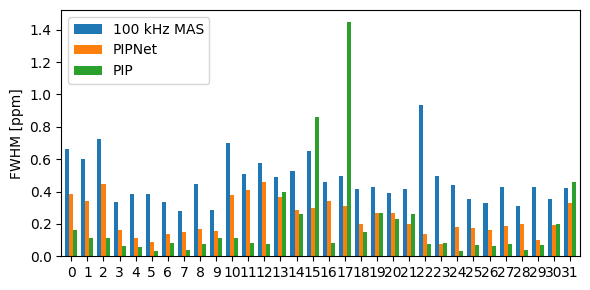

In [13]:
n = pks_exp.shape[0]
dx = 0.25

fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(1,1,1)
ax.bar(np.arange(n)-dx, lws_exp, width=dx)
ax.bar(np.arange(n), lws_sel, width=dx)
ax.bar(np.arange(n)+dx, lws_pip, width=dx)
ax.legend(["100 kHz MAS", "PIPNet", "PIP"], loc="upper left")
ax.set_xticks(range(n))
ax.set_ylabel("FWHM [ppm]")
ax.set_xlim(-2.5*dx, (n-1)+2.5*dx)
fig.tight_layout()
fig.savefig(f"{fdir}fwhms.pdf")
plt.show()
plt.close()

In [14]:
ref_lws = [[9., 158.58], [5., 40.2], [3., 125.94], [18., 178.5], [21., 188.52], [23., 129.36], [26., 191.1]]

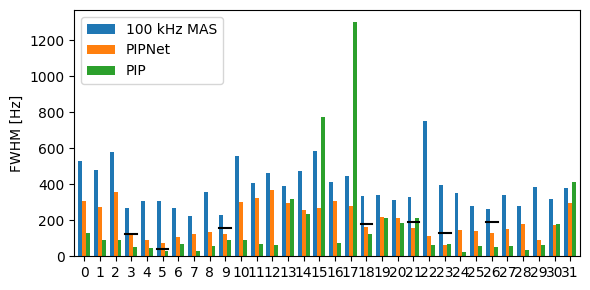

In [15]:
n = pks_exp.shape[0]
dx = 0.25

fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(1,1,1)
ax.bar(np.arange(n)-dx, lws_exp_hz, width=dx)
ax.bar(np.arange(n), lws_sel_hz, width=dx)
ax.bar(np.arange(n)+dx, lws_pip_hz, width=dx)
ax.legend(["100 kHz MAS", "PIPNet", "PIP"], loc="upper left")
for x, lw in ref_lws:
    ax.plot([x-1.5*dx, x+1.5*dx], [lw, lw], "k")
ax.set_xticks(range(n))
ax.set_ylabel("FWHM [Hz]")
ax.set_xlim(-2.5*dx, (n-1)+2.5*dx)
fig.tight_layout()
fig.savefig(f"{fdir}fwhms_hz.pdf")
plt.show()
plt.close()

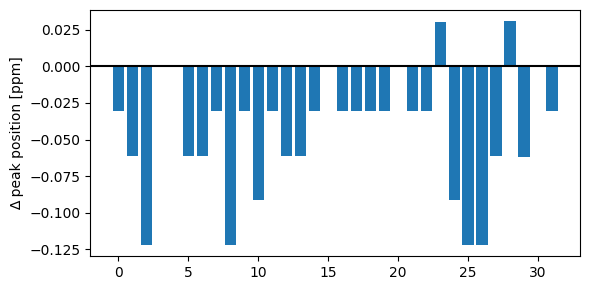

In [16]:
n = pks_exp.shape[0]
dx = 0.8

fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(1,1,1)
ax.bar(np.arange(n), pks_sel - pks_exp, width=dx, zorder=0)
ax.plot([-2.5*dx, (n-1)+2.5*dx], [0., 0.], "k", zorder=1)
ax.set_ylabel("∆ peak position [ppm]")
ax.set_xlim(-2.5*dx, (n-1)+2.5*dx)
fig.tight_layout()
fig.savefig(f"{fdir}peak_pos_diffs.pdf")
plt.show()
plt.close()

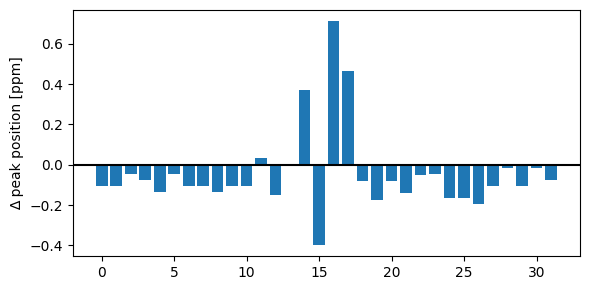

In [17]:
n = pks_exp.shape[0]
dx = 0.8

fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(1,1,1)
ax.bar(np.arange(n), pks_pip - pks_exp, width=dx, zorder=0)
ax.plot([-2.5*dx, (n-1)+2.5*dx], [0., 0.], "k", zorder=1)
ax.set_ylabel("∆ peak position [ppm]")
ax.set_xlim(-2.5*dx, (n-1)+2.5*dx)
fig.tight_layout()
fig.savefig(f"{fdir}peak_pos_diffs_pip.pdf")
plt.show()
plt.close()

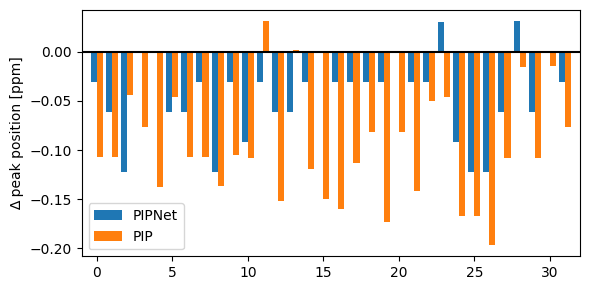

In [18]:
n = pks_exp.shape[0]
dx = 0.4

fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(1,1,1)
ax.bar(np.arange(n)-dx/2, pks_sel - pks_exp, width=dx, zorder=0)
ax.bar(np.arange(n)+dx/2, pks_pip - pks_exp, width=dx, zorder=0)
ax.legend(["PIPNet", "PIP"])
ax.plot([-2.5*dx, (n-1)+2.5*dx], [0., 0.], "k", zorder=1)
ax.set_ylabel("∆ peak position [ppm]")
ax.set_xlim(-2.5*dx, (n-1)+2.5*dx)
fig.tight_layout()
fig.savefig(f"{fdir}peak_pos_diffs_both.pdf")
plt.show()
plt.close()

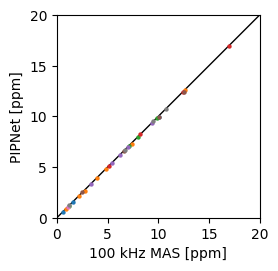

MAE: 0.04774334700862667
RMSE: 0.060108293232813394
R2: 0.999906806044351


In [19]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(1,1,1)
ax.plot([0., 20.], [0., 20.], "k", linewidth=1., zorder=0)
for x, y in zip(all_exp_pks, all_sel_pks):
    ax.scatter(x, y, s=10, linewidth=0., zorder=1)

ax.set_xlim(0., 20.)
ax.set_ylim(0., 20.)
ax.set_aspect("equal", "box")
ax.set_xlabel("100 kHz MAS [ppm]")
ax.set_ylabel("PIPNet [ppm]")
fig.tight_layout()
fig.savefig(f"{fdir}peak_pos.pdf")
plt.show()
plt.close()

print("MAE:", np.mean(np.abs(pks_exp - pks_sel)))
print("RMSE:", np.sqrt(np.mean(np.square(pks_exp - pks_sel))))

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(pks_exp, pks_sel)
print("R2:", r_value**2)

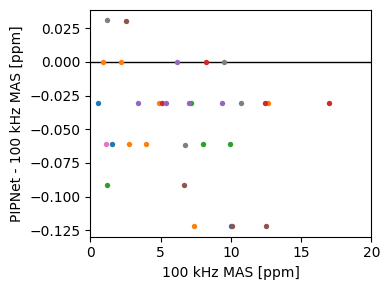

MAE: 0.04774334700862667
RMSE: 0.060108293232813394
R2: 0.999906806044351


In [30]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)
ax.plot([0., 20.], [0., 0.], "k", linewidth=1., zorder=0)
for x, y in zip(all_exp_pks, all_sel_pks):
    ax.scatter(x, y-x, s=15, linewidth=0., zorder=1)

ax.set_xlim(0., 20.)
ax.set_xlabel("100 kHz MAS [ppm]")
ax.set_ylabel("PIPNet - 100 kHz MAS [ppm]")
fig.tight_layout()
fig.savefig(f"{fdir}peak_pos_diff.pdf")
plt.show()
plt.close()

print("MAE:", np.mean(np.abs(pks_exp - pks_sel)))
print("RMSE:", np.sqrt(np.mean(np.square(pks_exp - pks_sel))))

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(pks_exp, pks_sel)
print("R2:", r_value**2)

In [18]:
print(np.mean(lws_exp_hz / lws_sel_hz), np.std(lws_exp_hz / lws_sel_hz))
print(np.min(lws_exp_hz / lws_sel_hz), np.max(lws_exp_hz / lws_sel_hz))

2.165802004302922 1.474759996694771
1.0678641617172486 8.335482269070898


In [19]:
print(np.mean(lws_exp_hz / lws_pip_hz), np.std(lws_exp_hz / lws_pip_hz))
print(np.min(lws_exp_hz / lws_pip_hz), np.max(lws_exp_hz / lws_pip_hz))

5.660978937295878 3.8950608956354467
0.9175761606916452 18.987034002013687


In [20]:
x = np.concatenate(all_pip_lws)
y = np.concatenate(all_sel_lws)

print(np.mean(np.abs(x - y)), np.sqrt(np.mean(np.square(x - y))))

0.16101714502440745 0.21684123337267847


In [21]:
x = np.concatenate(all_pip_pks)
y = np.concatenate(all_sel_pks)

print(np.mean(np.abs(x - y)), np.sqrt(np.mean(np.square(x - y))))

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
print(r_value**2)

0.07412651621285193 0.08715712943327265
0.9996566452278


In [22]:
def plot_lw(all_lws_fit, all_lws_net, all_pks_fit, all_pks_net, compounds, save):

    fig = plt.figure(figsize=(8,3))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    
    ax1.plot([0., 0.5], [0., 0.5], "k", zorder=0)
    ax2.plot([0., 15.], [0., 15.], "k", zorder=0)

    for lws_fit, lws_net in zip(all_lws_fit, all_lws_net):
        ax1.scatter(lws_fit, lws_net, s=10, linewidths=0., zorder=1)

    hs = []
    for pks_fit, pks_net in zip(all_pks_fit, all_pks_net):
        h = ax2.scatter(pks_fit, pks_net, s=10, linewidths=0., zorder=1)
        hs.append(h)
        
    ax1.set_xlabel("PIP linewidth [ppm]")
    ax1.set_ylabel("PIPNet linewidth [ppm]")
    ax2.set_xlabel("PIP peak [ppm]")
    ax2.set_ylabel("PIPNet peak [ppm]")

    ax2.legend(hs, compounds, bbox_to_anchor=(1., 1.))

    ax1.set_xlim(0., 0.5)
    ax1.set_ylim(0., 0.5)
    ax2.set_xlim(0., 15.)
    ax2.set_ylim(0., 15.)
    fig.tight_layout()

    plt.savefig(f"{save}_preds.pdf")
    plt.close()

    fig = plt.figure(figsize=(8,3))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)

    for lws_fit, lws_net in zip(all_lws_fit, all_lws_net):
        ax1.scatter(lws_fit, lws_net - lws_fit, s=10, linewidths=0.)

    for pks_fit, pks_net in zip(all_pks_fit, all_pks_net):
        ax2.scatter(pks_fit, pks_net - pks_fit, s=10, linewidths=0.)

    ax1.set_xlabel("PIP linewidth [ppm]")
    ax1.set_ylabel("linewidth difference [ppm]")
    ax2.set_xlabel("PIP peak [ppm]")
    ax2.set_ylabel("peak difference [ppm]")

    lw_mae = np.mean(np.abs(np.concatenate(all_lws_fit) - np.concatenate(all_lws_net)))
    pk_mae = np.mean(np.abs(np.concatenate(all_pks_fit) - np.concatenate(all_pks_net)))

    ax1.title.set_text(f"MAE = {lw_mae:.2f} ppm")
    ax2.title.set_text(f"MAE = {pk_mae:.2f} ppm")

    ax2.legend(compounds, bbox_to_anchor=(1., 1.))

    fig.tight_layout()

    plt.savefig(f"{save}_preds_diff.pdf")
    plt.close()
    
    return

In [23]:
plot_lw(all_pip_lws, all_sel_lws, all_pip_pks, all_sel_pks, compounds, f"{fdir}linewidths_sel")
plot_lw(all_exp_lws, all_sel_lws, all_exp_pks, all_sel_pks, compounds, f"{fdir}linewidths_sel_exp")

In [24]:
def plot_integrals(all_X_int, all_y_int, compounds, int_regions, w=0.2, label_h=0.1, show=True, save=None):
    
    # Compound separations
    sep = []
    mid = []
    labels = []
    bounds = []
    i = 0
    for k in compounds:
        if k in int_regions:
            l = len(int_regions[k])
            labels.append(k)
            sep.append(i+l - 0.5)
            mid.append(i + (l / 2) - 0.5)
            i += l
            bounds.append([r[1] for r in int_regions[k][:-1]])
    sep = sep[:-1]
    
    err_avg = []
    err_std = []
    for xint, yint in zip(all_X_int, all_y_int):
        err_avg.append(np.mean(np.abs(xint-yint)))
        err_std.append(np.std(np.abs(xint-yint)))
    
    x = np.array(range(i))
    
    xint = np.concatenate(all_X_int)
    yint = np.concatenate(all_y_int)
    
    M = max(np.max(xint), np.max(yint)) * 1.1
    
    fig = plt.figure(figsize=(i*0.4,3))
    ax = fig.add_subplot(1,1,1)
    
    ax.bar(x-(w/2), xint, width=w)
    ax.bar(x+(w/2), yint, width=w)
    
    ax.legend(["100 kHz MAS", "PIPNet"], bbox_to_anchor=(0.,0.9), loc="upper left")
    
    for s in sep:
        ax.plot([s, s], [0., M], "k")
    
    lx = 0.5
    for b in bounds:
        for bi in b:
            ax.plot([lx, lx], [0, label_h], "k:")
            ax.text(lx, label_h, f" {bi} ppm", rotation=90, ha="center", va="bottom", size=8)
            lx += 1
        lx += 1
    
    for em, es, m in zip(err_avg, err_std, mid):
        ax.text(m, M*0.99, f"mae: {em:.3f}\n±{es:.3f}", ha="center", va="top", size=8)
    
    ax.set_xticks(mid)
    ax.set_xticklabels(labels)
    
    ax.set_ylabel("Relative integral")
    
    ax.set_ylim(0., M)
    ax.set_xlim(-0.5, i-0.5)
    
    if save is not None:
        plt.savefig(save)
    
    if show:
        plt.show()
    
    plt.close()
    
    return

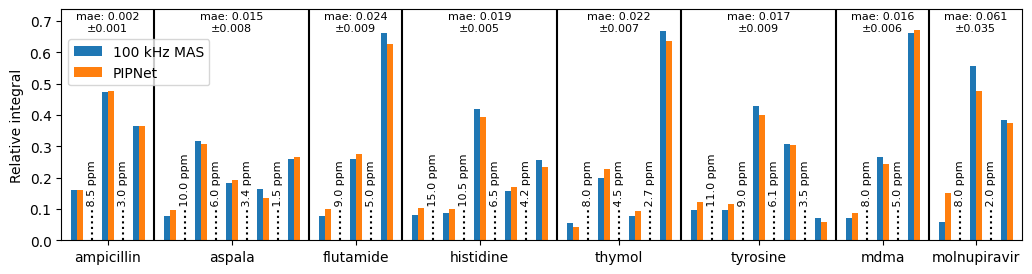

In [25]:
plot_integrals(all_exp_int, all_sel_int, compounds, int_regions, save=f"{fdir}integrals_sel.pdf")